In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

In [3]:
#Create your connection
cnx=sqlite3.connect('Data/database.sqlite')
df=pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

## Exploring Data

In [4]:
df.columns

Index([u'id', u'player_fifa_api_id', u'player_api_id', u'date',
       u'overall_rating', u'potential', u'preferred_foot',
       u'attacking_work_rate', u'defensive_work_rate', u'crossing',
       u'finishing', u'heading_accuracy', u'short_passing', u'volleys',
       u'dribbling', u'curve', u'free_kick_accuracy', u'long_passing',
       u'ball_control', u'acceleration', u'sprint_speed', u'agility',
       u'reactions', u'balance', u'shot_power', u'jumping', u'stamina',
       u'strength', u'long_shots', u'aggression', u'interceptions',
       u'positioning', u'vision', u'penalties', u'marking', u'standing_tackle',
       u'sliding_tackle', u'gk_diving', u'gk_handling', u'gk_kicking',
       u'gk_positioning', u'gk_reflexes'],
      dtype='object')

In [6]:
df.describe().transpose().head()

,count,mean,std,min,25%,50%,75%,max
id,183978.0,91989.500000,53110.018250,1.0,45995.25,91989.5,137983.75,183978.0
player_fifa_api_id,183978.0,165671.524291,53851.094769,2.0,155798.00,183488.0,199848.00,234141.0
player_api_id,183978.0,135900.617324,136927.840510,2625.0,34763.00,77741.0,191080.00,750584.0
overall_rating,183142.0,68.600015,7.041139,33.0,64.00,69.0,73.00,94.0
potential,183142.0,73.460353,6.592271,39.0,69.00,74.0,78.00,97.0


## Data Cleaning: Handling Missing Data

Real data is never clean. We need to make sure we clean the data by vonverting or getting rid of null or missing values. The next code cell will show you if any of the 183978 row have null value in one of the 42 columns

In [7]:
# is any row null?
df.isnull().any().any(), df.shape

(True, (183978, 42))

In [8]:
df.isnull().sum(axis=0)

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

## Fixing Null Values by Deleting Them

In our next two lines, we will drop the null values by going through each row.

In [9]:
# fix it
# take initial # of rows
rows=df.shape[0]

#Drop the null rows
df=df.dropna()

Now if we check the null values and number of rows, we will see that there are no null values and number of rows decreased accordingly.

In [10]:
# check if all Null are gone?
print(rows)
df.isnull().any().any(), df.shape

183978


(False, (180354, 42))

To find exactly how mnay lines we removed, we need to substract the current number of rows in our data frame from the original number of rows.

In [11]:
# How mnay rows with Null values?

rows-df.shape[0]

3624

Our dataset has many lines as you have seen. We can only look at few lines at once. Instead of looking at same top 10 lines every time, we shuffle-so we get to see different random sample on top. This way, we make sure the data is not in any particular order when we try sampling from it (like taking top or bottom few rows) by randomly shuffling the rows.

In [13]:
# Shuffle the rows of df so we get a distributed sample when we display top few rows
df=df.reindex(np.random.permutation(df.index))

## Predicting: 'overall_rating' of a player
Now that our data cleaning step is reasonably complete and we can trust and understand the data more, we will start diving into the dataset further.

### Let's take a look at top few rows.

In [14]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
138783,138784,210527,158845,2014-01-24 00:00:00,64.0,70.0,right,medium,medium,39.0,...,43.0,46.0,68.0,69.0,62.0,10.0,10.0,9.0,12.0,12.0
80792,80793,183283,94030,2007-08-30 00:00:00,46.0,74.0,right,medium,medium,27.0,...,56.0,37.0,47.0,50.0,62.0,7.0,21.0,35.0,21.0,21.0
75296,75297,147007,37461,2013-03-28 00:00:00,73.0,76.0,left,medium,low,82.0,...,77.0,71.0,31.0,44.0,21.0,12.0,14.0,14.0,6.0,7.0
144938,144939,229758,438456,2016-05-12 00:00:00,67.0,75.0,right,medium,medium,59.0,...,68.0,58.0,41.0,45.0,45.0,14.0,9.0,12.0,10.0,14.0
8663,8664,195586,129918,2011-02-22 00:00:00,64.0,75.0,right,medium,medium,28.0,...,39.0,69.0,22.0,17.0,11.0,5.0,14.0,15.0,14.0,10.0


In [15]:
df[:10][['penalties', 'overall_rating']]

,penalties,overall_rating
138783,46.0,64.0
80792,37.0,46.0
75296,71.0,73.0
144938,58.0,67.0
8663,69.0,64.0
20085,56.0,83.0
73956,39.0,63.0
46582,40.0,58.0
16925,47.0,64.0
3450,68.0,68.0


## Feature Correlation Analysis
Next, we will check if 'penalties' is correlated to 'overall_rating'. We are using a similar selection operation, but htis time for all the rows and within the correlation function.

### create a list of potential features that you want to measure correlation with

In [16]:
potentialFeatures=['acceleration', 'curve', 'free_kick_accuracy', 'ball_control', 'shot_power', 'stamina']

The for loop below prints out the correlation coefficient of "overall_rating" of a player with each feature we added to the list as potential.

In [17]:
# check how the features are correlated with the overall ratings
for f in potentialFeatures:
    related=df['overall_rating'].corr(df[f])
    print("%s: %f" % (f, related))

acceleration: 0.243998
curve: 0.357566
free_kick_accuracy: 0.349800
ball_control: 0.443991
shot_power: 0.428053
stamina: 0.325606


## Data Visualization:

Next we will start plotting the correlation coefficients of each feature with "overall_rating". We start by selecting columns and creating a list with correlation coefficients, called "correlations".

In [18]:
corr_matrix=df.corr()
corr_matrix["overall_rating"].sort_values(ascending=False)

overall_rating        1.000000
reactions             0.771856
potential             0.765435
short_passing         0.458243
ball_control          0.443991
long_passing          0.434525
vision                0.431493
shot_power            0.428053
penalties             0.392715
long_shots            0.392668
positioning           0.368978
volleys               0.361739
curve                 0.357566
crossing              0.357320
dribbling             0.354191
free_kick_accuracy    0.349800
finishing             0.330079
stamina               0.325606
aggression            0.322782
strength              0.315684
heading_accuracy      0.313324
jumping               0.258978
sprint_speed          0.253048
interceptions         0.249094
acceleration          0.243998
agility               0.239963
standing_tackle       0.163986
balance               0.160211
marking               0.132185
sliding_tackle        0.128054
gk_kicking            0.028799
gk_diving             0.027675
gk_posit

In [19]:
cols = ['potential',  'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes']

In [20]:
# create a list containing Pearson's correlation between 'overall_rating' with each column in cols
correlations=[df['overall_rating'].corr(df[f]) for f in cols]

In [21]:
len(cols), len(correlations)

(34, 34)

We make sure that the number of selected features and the correlations calculated are the same, e.g., both 34 in this case. Next couple of cells show some lines of code that use pandas plotting functions to create a 2D graph of these correlation values and column names.

In [24]:
# create a function for plotting a dataframe with string columns and numeric values

def plot_dataframe(df, y_label):
    color='coral'
    fig=plt.gcf()
    fig.set_size_inches(20,12)
    plt.ylabel(y_label)
    
    ax=df.correlation.plot(linewidth=3.3, color=color)
    ax.set_xticks(df.index)
    ax.set_xticklabels(df.attributes, rotation=75)# Notice the; (remove it and see ehat happends!)
    plt.show()

In [25]:
# create a dateframe using cols and correlations

df2=pd.DataFrame({'attributes': cols, 'correlation': correlations})

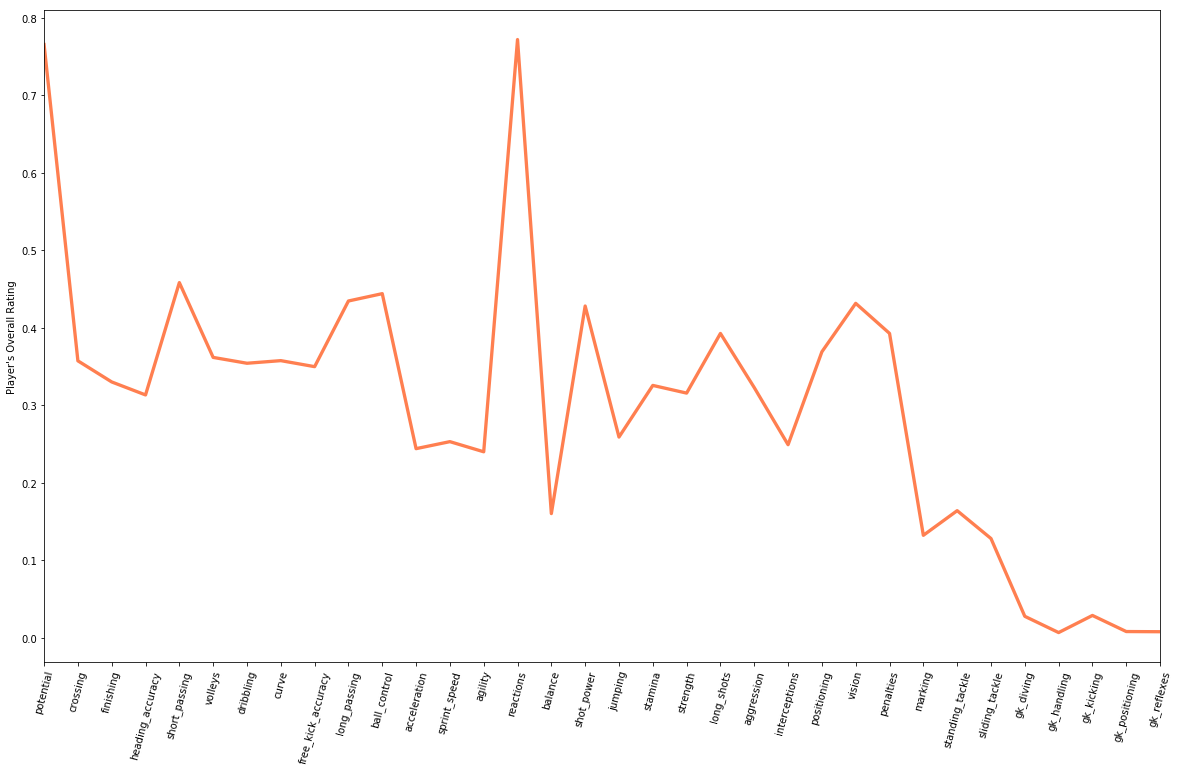

In [27]:
# let's plot above dataframe using the function we created
plot_dataframe(df2, 'Player\'s Overall Rating')

## Clustering Players into Similar Groups
Until now, we used basic statistics and correlation coefficients to start forming an opinion, but we can do better? What if we took some features and start looking at each player using those features? Can we group simialr players based on these features? Let's see how we can do this.

### Select Features on Which to group Players

In [28]:
# Define the features you want to use for grouping players
select5features=['gk_kicking', 'potential', 'marking', 'interceptions', 'standing_tackle']
select5features

['gk_kicking', 'potential', 'marking', 'interceptions', 'standing_tackle']

In [29]:
# Generate a new dataframe by selecting the features you just defined

df_select=df[select5features].copy(deep=True)

In [33]:
df_select.head()

,gk_kicking,potential,marking,interceptions,standing_tackle
138783,9.0,70.0,68.0,68.0,69.0
80792,35.0,74.0,47.0,28.0,50.0
75296,14.0,76.0,31.0,20.0,44.0
144938,12.0,75.0,41.0,25.0,45.0
8663,15.0,75.0,22.0,19.0,17.0


## Perform KMeans Clustering
Now we will use a machine learning method called KMeans to cluster the values(i.e., player features on gk_kicking, potential, marking, interceptions, and standing_tackle). We will ask for four clusters. 

In [34]:
# Perform scaling on the dataframe containing the features

data=scale(df_select)

#Define number of clusters
noOfClusters=4

#Train a model
model=KMeans(init='k-means++', n_clusters=noOfClusters, n_init=20). fit(data)

In [36]:
print(90*'_')
print("\nCount of players in each cluster")
print(90*'_')

pd.value_counts(model.labels_,sort=False)

__________________________________________________________________________________________

Count of players in each cluster
__________________________________________________________________________________________


0    55883
1    50553
2    23786
3    50132
dtype: int64

In [43]:
def pd_centers(featuresUsed, centers):
    from itertools import cycle, islice
    from pandas.tools.plotting import parallel_coordinates
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    
    colNames=list(featuresUsed)
    colNames.append('prediction')
    #Zip with a column called 'prediction' (index)
    Z=[np.append(A,index) for index, A in enumerate(centers)]
    
    #convert to pandas for plotting
    P=pd.DataFrame(Z, columns=colNames)
    P['prediction']=P['prediction'].astype(int)
    return P

def parallel_plot(data):
    from itertools import cycle, islice
    from pandas.tools.plotting import parallel_coordinates
    import matplotlib.pyplot as plt
    
    my_colors=list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-2.5, +2.5])
    parallel_coordinates(data, 'prediction', color=my_colors, marker='o')

In [40]:
# create a composite dataframe for plotting
#...Use custom function declared in customplot.py (which we imported at the begining of this notebook)

P=pd_centers(featuresUsed=select5features, centers=model.cluster_centers_)
P

,gk_kicking,potential,marking,interceptions,standing_tackle,prediction
0,-0.477149,0.106108,-0.947855,-0.975381,-0.914320,0
1,-0.043644,0.702859,1.027407,0.982489,1.030165,1
2,1.920628,0.038970,-1.111134,-0.652297,-1.200427,2
3,-0.335323,-0.845682,0.547628,0.405917,0.549828,3


## Visualization of Clusters
We now have 4 clusters based on the features we selected, we can treat them as profiles for simialr groups of players. We can visualize these profiles by plotting the centers for each cluster, i.e., the average value for each feature within the cluster. We will use matplotlib for this visualization. 

In [44]:
# for plotting the graph inside the notebook itself, we use the follosing command
%matplotlib inline

/Users/jingchen/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.


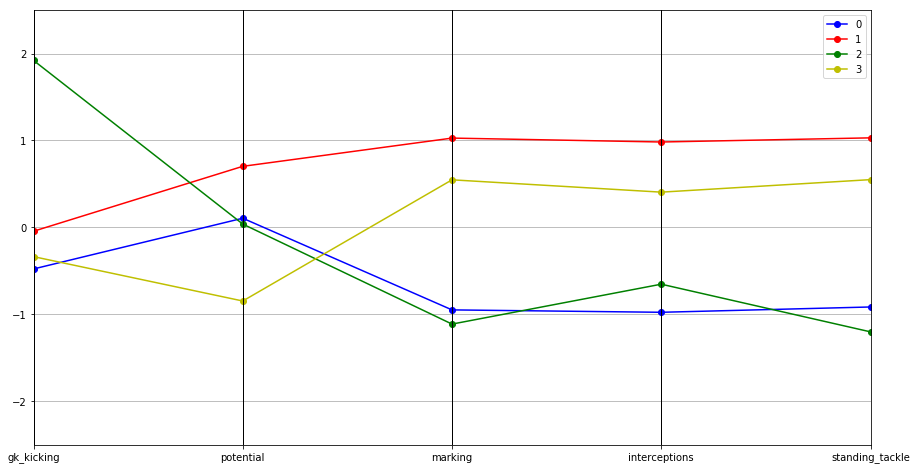

In [45]:
parallel_plot(P)

### Analysis of Findings
### Can we indentify the groups for each of the below?
1) Two groups are similar except in gk_kicking_these players can coach each other on gk_kicking, where they differ

2) Two groups are somewhat similar to each other except in potential